# Digit Recognizer

Created by Zach Brazil, Richard Charles, Adam Kiehl, Zane Perkins

### Setup

In [48]:
# Import packages
import os
import glob
import shutil
import plotnine

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

from plotnine import ggplot
from plotnine import aes 
from plotnine import geom_line
from plotnine import labs

In [49]:
# Reproducibility
np.random.seed(478)
tf.random.set_seed(478)

In [50]:
# Read in data from .csv files
train = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')

# Convert Pandas dataframes to valid Numpy arrays
def convert(X):
    data = np.empty((X.shape[0], 28, 28, 1))
    for i in range(X.shape[0]):
        img = np.array(X.iloc[i, :]).reshape((28, 28, 1))
        data[i] = img
    return(np.array(data))

# Define training set
X_train = convert(train.drop('label', axis = 1)) / 255
y_train = train['label']

# Define testing set
X_test = convert(test) / 255

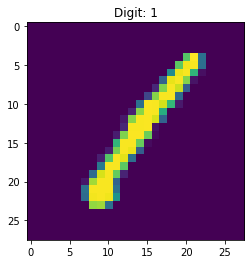

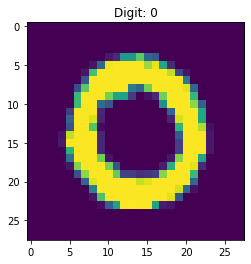

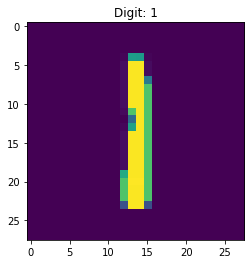

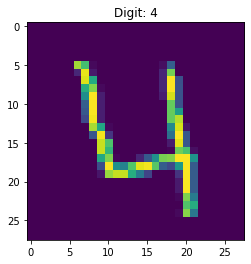

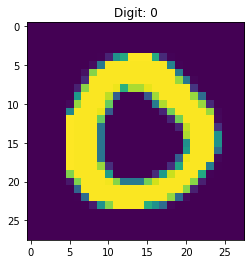

In [51]:
# Plot example digit images
for i in range(5):
    plt.imshow(X_train[i]) 
    plt.title(f"Digit: {y_train[i]}")
    plt.show() 

### Modeling

In [60]:
# Define model architecture
model = keras.Sequential([
    # layers.Lambda(standardize, input_shape = (28, 28, 1)),
    layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', input_shape = [28, 28, 1]),
    layers.MaxPool2D(3),

    # layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu'),

    layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu'),

    layers.DepthwiseConv2D(kernel_size = 3, depth_multiplier = 4, activation = 'relu'),
    layers.MaxPool2D(3),

    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(.1),
    layers.Dense(10, activation = 'softmax')
])

model.summary()

# Compile model
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 6, 6, 64)          18496     
_________________________________________________________________
depthwise_conv2d_16 (Depthwi (None, 4, 4, 256)         2560      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 1, 1, 256)         0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 512)             

In [56]:
# Define number of training epochs
EPOCHS = 10

# Train model with 75/25 training/validation split
trained = model.fit(
    X_train,
    y_train,
    epochs = EPOCHS,
    validation_split = .25
)

Epoch 1/10
985/985 [==============================] - 9s 8ms/step - loss: 0.8679 - accuracy: 0.7186 - val_loss: 0.1572 - val_accuracy: 0.9516
Epoch 2/10
985/985 [==============================] - 8s 8ms/step - loss: 0.1592 - accuracy: 0.9518 - val_loss: 0.1126 - val_accuracy: 0.9654
Epoch 3/10
985/985 [==============================] - 8s 8ms/step - loss: 0.1061 - accuracy: 0.9660 - val_loss: 0.0826 - val_accuracy: 0.9744
Epoch 4/10
985/985 [==============================] - 7s 8ms/step - loss: 0.0797 - accuracy: 0.9754 - val_loss: 0.0827 - val_accuracy: 0.9743
Epoch 5/10
985/985 [==============================] - 7s 8ms/step - loss: 0.0669 - accuracy: 0.9788 - val_loss: 0.0691 - val_accuracy: 0.9791
Epoch 6/10
985/985 [==============================] - 8s 8ms/step - loss: 0.0605 - accuracy: 0.9795 - val_loss: 0.0624 - val_accuracy: 0.9806
Epoch 7/10
985/985 [==============================] - 7s 8ms/step - loss: 0.0469 - accuracy: 0.9849 - val_loss: 0.0704 - val_accuracy: 0.9785
Epoch 

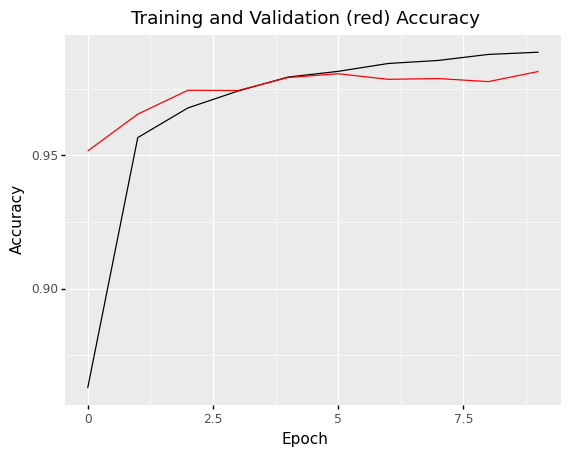

<ggplot: (8775591171476)>

In [57]:
# Plot training and validation accuracy
(
    ggplot() 
    + geom_line(aes(range(EPOCHS), trained.history['accuracy']))
    + geom_line(aes(range(EPOCHS), trained.history['val_accuracy']), color = 'red')
    + labs(title='Training and Validation (red) Accuracy', x='Epoch', y='Accuracy')
)

### Prediction

In [61]:
# Choose 5 epochs to avoid overfitting
EPOCHS = 5

# Retrain model on full training set
trained_full = model.fit(
    X_train,
    y_train,
    epochs = EPOCHS,
    validation_split = 0
)

Epoch 1/5
1313/1313 [==============================] - 10s 8ms/step - loss: 0.6730 - accuracy: 0.7807
Epoch 2/5
1313/1313 [==============================] - 10s 8ms/step - loss: 0.1025 - accuracy: 0.9674
Epoch 3/5
1313/1313 [==============================] - 10s 8ms/step - loss: 0.0724 - accuracy: 0.9766
Epoch 4/5
1313/1313 [==============================] - 10s 8ms/step - loss: 0.0563 - accuracy: 0.9815
Epoch 5/5
1313/1313 [==============================] - 10s 7ms/step - loss: 0.0480 - accuracy: 0.9852


In [62]:
# Generate competition preedictions based on test set
pred = pd.DataFrame(model.predict(X_test)).idxmax(axis = 1)
submission = pd.DataFrame({'ImageId': range(1, len(pred) + 1), 'Label': pred})
submission.head()

# Write submission results to local .csv file
submission.to_csv('./Data/submission.csv', index=False)